## LangGraph ReAct Agent with Tools
Learning Objectives:
- Create tools (functions) that LLMs can call
- Implement the ReAct pattern (Reasoning + Acting)
- Build an agent that decides when to use tools

#### 
Real-World Tools:
-----------------
- Database queries
- API calls (weather, stock prices, etc.)
- File operations
- Web searches
- Send emails/notifications
- Execute code
- Image generation
- Data analysis

### Agent Patterns
- Chain of Thoughts (CoT)
- Tree of Thoughts (ToT)
- ReAct

In [15]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
from typing_extensions import TypedDict, Annotated
import operator
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage

from langgraph.prebuilt import ToolNode

# Configuration
BASE_URL = "http://localhost:11434"
MODEL_NAME = "qwen3" # llama 3.2
# gemma3, deepseek-r1 -< they don't have tools support yet

llm = ChatOllama(model=MODEL_NAME, base_url=BASE_URL)

In [2]:
class AgentState(TypedDict):
    messages: Annotated[list, operator.add]

#### Agent Node

In [9]:
## Tool usage
import my_tools

# my_tools.get_weather.invoke({'location': "Mumbai"})

my_tools.calculate.invoke({'expression': '2+2*1.4/23-34'})

all_tools = [my_tools.get_weather, my_tools.calculate]

[TOOL] calculate ('2+2*1.4/23-34') -> '-31.878260869565217'


In [19]:
## Agent Node

def agent_node(state: AgentState):

    llm_with_tools = llm.bind_tools(all_tools)

    messages = state['messages']

    response = llm_with_tools.invoke(messages)

    if hasattr(response, 'tool_calls') and response.tool_calls:
        for tc in response.tool_calls:
            print(f"[AGENT] called Tool {tc.get('name', '?')} with args {tc.get('args', '?')}")
    else:
        print(f"[AGENT] Responding...")


    return {'messages': [response]}

In [20]:
state = {"messages": [HumanMessage("Hi")]}
result = agent_node(state)

[AGENT] Responding...


In [21]:
result

{'messages': [AIMessage(content='Hello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-11-05T07:39:40.6214629Z', 'done': True, 'done_reason': 'stop', 'total_duration': 4755028300, 'load_duration': 3235384500, 'prompt_eval_count': 457, 'prompt_eval_duration': 99282700, 'eval_count': 98, 'eval_duration': 1394561700, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--ae4a46fa-01ec-4002-aa08-2ef9c31e85e1-0', usage_metadata={'input_tokens': 457, 'output_tokens': 98, 'total_tokens': 555})]}

In [22]:
state = {"messages": [HumanMessage("Hi, what is 2+2?")]}
result = agent_node(state)
result

[AGENT] called Tool calculate with args {'expression': '2 + 2'}


{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-11-05T07:39:44.4358572Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2323922800, 'load_duration': 70265300, 'prompt_eval_count': 465, 'prompt_eval_duration': 50755600, 'eval_count': 155, 'eval_duration': 2173851600, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--4195f707-661e-4e4f-9717-1eb7fe747a97-0', tool_calls=[{'name': 'calculate', 'args': {'expression': '2 + 2'}, 'id': '51147d12-bbf3-4baa-a2cf-f996409877d8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 465, 'output_tokens': 155, 'total_tokens': 620})]}

### Routing

In [23]:
lst = [1,2,3,4]
lst[-1]

4

In [24]:
def should_continue(state: AgentState):
    last = state['messages'][-1]
    
    if hasattr(last, 'tool_calls') and last.tool_calls:
        return "tools"
    

    else:
        return END

In [27]:
# =============================================================================
# Graph
# =============================================================================
def create_agent():

    builder = StateGraph(AgentState)

    builder.add_node("agent", agent_node)
    builder.add_node("tools", ToolNode(all_tools))


    builder.add_edge(START, "agent")
    builder.add_conditional_edges("agent", should_continue, ["tools", END])

    builder.add_edge("tools", "agent")

    graph = builder.compile()

    return graph

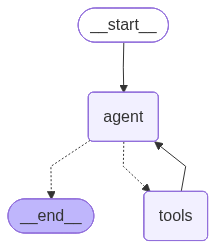

In [29]:
agent = create_agent()
agent

In [32]:
query = "What is the current weather in Mumbai?"

result = agent.invoke({'messages': [HumanMessage(query)]})

[AGENT] called Tool get_weather with args {'location': 'Mumbai'}
[AGENT] Responding...


In [33]:
result

{'messages': [HumanMessage(content='What is the current weather in Mumbai?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-11-05T08:03:11.3606299Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1417494300, 'load_duration': 65538000, 'prompt_eval_count': 464, 'prompt_eval_duration': 6866700, 'eval_count': 115, 'eval_duration': 1325075700, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--c3dca123-ef97-426b-8427-a5c4f07ece93-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Mumbai'}, 'id': '82124c08-9579-40e0-ad8b-384b570bb676', 'type': 'tool_call'}], usage_metadata={'input_tokens': 464, 'output_tokens': 115, 'total_tokens': 579}),
  ToolMessage(content='{"current_condition": [{"FeelsLikeC": "34", "FeelsLikeF": "93", "cloudcover": "25", "humidity": "59", "localObsDateTime": "2025-11-05 01:09 PM", "observation_time": "07:39 AM", "precipInches": "0.0", "

In [36]:
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

The current weather in Mumbai is **clear skies** with a temperature of **26°C (79°F)**. The feels-like temperature is **28°C (82°F)**, and the humidity is at **64%**. Wind is coming from the **WNW** at **7 km/h (4 mph)**. The UV index is low at **0**, indicating minimal sun exposure. 

For the next few days, there's a chance of patchy rain and light showers, but today's weather remains sunny with occasional clouds.


In [37]:
query = "What is the current weather in Mumbai? and What is 4*56 and 3-90"

result = agent.invoke({'messages': [HumanMessage(query)]})

[AGENT] called Tool get_weather with args {'location': 'Mumbai'}
[AGENT] called Tool calculate with args {'expression': '4*56'}
[AGENT] called Tool calculate with args {'expression': '3-90'}
[TOOL] calculate ('4*56') -> '224'
[TOOL] calculate ('3-90') -> '-87'
[AGENT] Responding...


In [38]:
result

{'messages': [HumanMessage(content='What is the current weather in Mumbai? and What is 4*56 and 3-90', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-11-05T08:10:42.3133874Z', 'done': True, 'done_reason': 'stop', 'total_duration': 9302352600, 'load_duration': 2924669900, 'prompt_eval_count': 478, 'prompt_eval_duration': 69192700, 'eval_count': 495, 'eval_duration': 6210976500, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--7087cc69-58f8-422a-bfe2-2a0979b479f9-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Mumbai'}, 'id': 'f3b1229a-37ac-473d-b454-6fc60f507eda', 'type': 'tool_call'}, {'name': 'calculate', 'args': {'expression': '4*56'}, 'id': 'ccf8a9b9-5e50-4340-b91c-6990ddf2a7a8', 'type': 'tool_call'}, {'name': 'calculate', 'args': {'expression': '3-90'}, 'id': '908ac0fb-d570-4ce7-8a92-2bda92f27b1e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 4

In [39]:
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

The current weather in Mumbai is **30°C** with **Smoke** conditions. 

- **4 × 56 = 224**  
- **3 − 90 = -87**  

Let me know if you need further details! 🌦️🧮
